# Libraries

In [13]:
from tensorflow.keras.applications import VGG16
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Open Pose

MPII Output Format:
Head – 0
Neck – 1
Right Shoulder – 2
Right Elbow – 3
Right Wrist – 4
Left Shoulder – 5
Left Elbow – 6
Left Wrist – 7
Right Hip – 8
Right Knee – 9
Right Ankle – 10
Left Hip – 11
Left Knee – 12
Left Ankle – 13
Chest – 14
Background – 15

In [14]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

# Importing VGG 16

In [15]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Using ImageDataGenerator

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
base_dir = 'DataBaseCustom/DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
test_dir = os.path.join(base_dir, 'TEST')

base_dir_op = 'DataBaseCustom/DATASET_OP'
train_dir_op = os.path.join(base_dir_op, 'TRAIN')
test_dir_op = os.path.join(base_dir_op, 'TEST')

base_dir_black = 'DataBaseCustom/DATASET_BLACK'
train_dir_black = os.path.join(base_dir_black, 'TRAIN')
test_dir_black = os.path.join(base_dir_black, 'TEST')

In [19]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [20]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count, 5))
    #labels = np.zeros(shape = (sample_count, 2)) edited to two as my custom image directory has only two classes.
    generator = datagen.flow_from_directory(directory, target_size = (150, 150), batch_size = batch_size, class_mode="categorical",subset = "training")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        print(i * batch_size)
        if i * batch_size >= sample_count:
            break
    return features, labels

# Classifier

In [21]:
from tensorflow.keras import models, layers, optimizers

In [22]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'softmax'))

In [23]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss = 'categorical_crossentropy', metrics = ['acc'])

# Input label and features

In [26]:
train_features, train_labels = extract_features(train_dir, 1074)
test_features, test_labels = extract_features(test_dir, 466)

Found 1074 images belonging to 5 classes.
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
Found 466 images belonging to 5 classes.
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


In [27]:
train_features = np.reshape(train_features, (1074, 4 * 4 * 512))
test_features = np.reshape(test_features, (466, 4 * 4 * 512))

In [28]:
history = model.fit(train_features, train_labels, epochs = 50, batch_size = 20)

Epoch 1/50
54/54 [==============================] - 2s 38ms/step - loss: 1.7127 - acc: 0.2803
Epoch 2/50
54/54 [==============================] - 2s 33ms/step - loss: 1.3344 - acc: 0.4553
Epoch 3/50
54/54 [==============================] - 2s 32ms/step - loss: 1.1457 - acc: 0.5764
Epoch 4/50
54/54 [==============================] - 2s 37ms/step - loss: 0.9812 - acc: 0.6629
Epoch 5/50
54/54 [==============================] - 2s 33ms/step - loss: 0.8860 - acc: 0.6816
Epoch 6/50
54/54 [==============================] - 2s 34ms/step - loss: 0.7978 - acc: 0.7458
Epoch 7/50
54/54 [==============================] - 2s 35ms/step - loss: 0.7189 - acc: 0.7588
Epoch 8/50
54/54 [==============================] - 2s 35ms/step - loss: 0.6878 - acc: 0.7942
Epoch 9/50
54/54 [==============================] - 2s 33ms/step - loss: 0.6171 - acc: 0.8110
Epoch 10/50
54/54 [==============================] - 2s 33ms/step - loss: 0.5953 - acc: 0.8166: 1s - l
Epoch 11/50
54/54 [==============================] 

In [29]:
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)

15/15 - 0s - loss: 0.2416 - acc: 0.9356


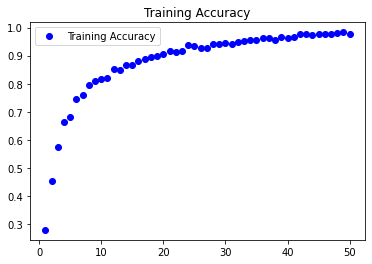

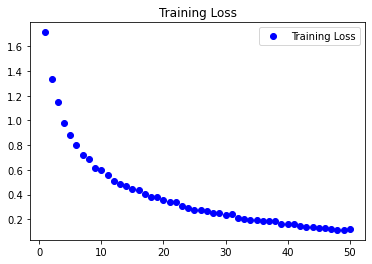

In [30]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label= 'Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [31]:
model.save('YogaPoseClassifierRegularCustomDB.h5')

# Open Pose Only

In [33]:
train_features_black, train_labels_black = extract_features(train_dir_black, 1082)
test_features_black, test_labels_black = extract_features(test_dir_black, 469)

Found 1082 images belonging to 5 classes.
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
Found 469 images belonging to 5 classes.
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


In [34]:
train_features_black = np.reshape(train_features_black, (1082, 4 * 4 * 512))
test_features_black = np.reshape(test_features_black, (469, 4 * 4 * 512))

In [35]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'softmax'))

In [36]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss = 'categorical_crossentropy', metrics = ['acc'])

In [37]:
history = model.fit(train_features_black, train_labels_black, epochs = 50, batch_size = 20)

Epoch 1/50
55/55 [==============================] - 2s 35ms/step - loss: 1.6735 - acc: 0.2606
Epoch 2/50
55/55 [==============================] - 2s 40ms/step - loss: 1.4539 - acc: 0.3882
Epoch 3/50
55/55 [==============================] - 2s 36ms/step - loss: 1.3237 - acc: 0.4843
Epoch 4/50
55/55 [==============================] - 2s 35ms/step - loss: 1.2187 - acc: 0.5296
Epoch 5/50
55/55 [==============================] - 2s 33ms/step - loss: 1.1181 - acc: 0.5961
Epoch 6/50
55/55 [==============================] - 2s 31ms/step - loss: 1.0764 - acc: 0.6220
Epoch 7/50
55/55 [==============================] - 2s 31ms/step - loss: 1.0268 - acc: 0.6506
Epoch 8/50
55/55 [==============================] - 2s 35ms/step - loss: 0.9674 - acc: 0.6710
Epoch 9/50
55/55 [==============================] - 2s 31ms/step - loss: 0.9473 - acc: 0.6765
Epoch 10/50
55/55 [==============================] - 2s 31ms/step - loss: 0.9124 - acc: 0.6885
Epoch 11/50
55/55 [==============================] - 3s 46m

In [38]:
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)

15/15 - 0s - loss: 1.1688 - acc: 0.5644


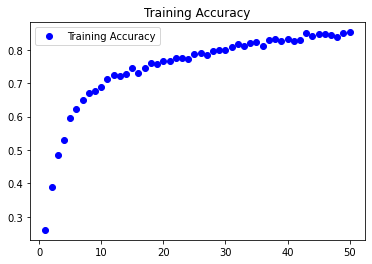

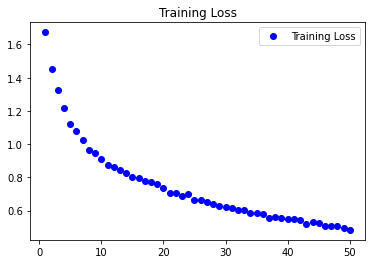

In [39]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label= 'Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [40]:
model.save('YogaPoseClassifierBlackCustomDB.h5')

# Open Pose and Image

In [42]:
train_features_op, train_labels_op = extract_features(train_dir_op, 1082)
test_features_op, test_labels_op = extract_features(test_dir_op, 469)

Found 1082 images belonging to 5 classes.
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
Found 469 images belonging to 5 classes.
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480


In [43]:
train_features_op = np.reshape(train_features_op, (1082, 4 * 4 * 512))
test_features_op = np.reshape(test_features_op, (469, 4 * 4 * 512))

In [44]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'softmax'))

In [45]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss = 'categorical_crossentropy', metrics = ['acc'])

In [46]:
history = model.fit(train_features_op, train_labels_op, epochs = 50, batch_size = 20)

Epoch 1/50
55/55 [==============================] - 2s 34ms/step - loss: 1.6717 - acc: 0.2893
Epoch 2/50
55/55 [==============================] - 2s 35ms/step - loss: 1.3663 - acc: 0.4372: 1s -
Epoch 3/50
55/55 [==============================] - 2s 34ms/step - loss: 1.1080 - acc: 0.5878
Epoch 4/50
55/55 [==============================] - 2s 34ms/step - loss: 0.9864 - acc: 0.6590
Epoch 5/50
55/55 [==============================] - 2s 34ms/step - loss: 0.8737 - acc: 0.7116
Epoch 6/50
55/55 [==============================] - 2s 34ms/step - loss: 0.8091 - acc: 0.7329
Epoch 7/50
55/55 [==============================] - 2s 34ms/step - loss: 0.7408 - acc: 0.7726
Epoch 8/50
55/55 [==============================] - 2s 35ms/step - loss: 0.6710 - acc: 0.7902
Epoch 9/50
55/55 [==============================] - 2s 36ms/step - loss: 0.6347 - acc: 0.7994
Epoch 10/50
55/55 [==============================] - 2s 40ms/step - loss: 0.6127 - acc: 0.8105
Epoch 11/50
55/55 [==============================] - 

In [47]:
test_loss, test_acc = model.evaluate(test_features_op, test_labels_op, verbose=2)

15/15 - 0s - loss: 0.2608 - acc: 0.9147


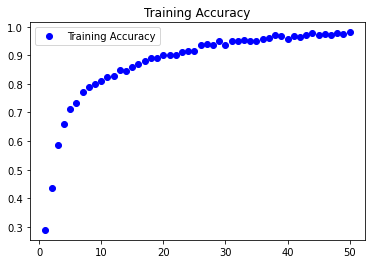

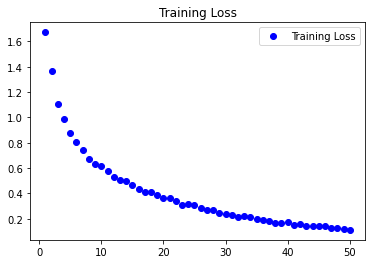

In [48]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label= 'Training Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [49]:
model.save('YogaPoseClassifierOpCustomDB.h5')